# The Simpsons

## Preparations

### Import libraries

- Tensorflow: Machine Learning Library
- Matplotlib: Plotting (math) library

In [52]:
import tensorflow as tf
from matplotlib import image
from tensorflow.keras import datasets, layers, models, Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import itertools
import glob
from sklearn import preprocessing, metrics

In [53]:
import warnings

#warnings.filterwarnings('ignore')

### Select Characters

Create a list of characters that we want to recognise

In [62]:
selected_characters = [
    "abraham_grampa_simpson",
    # "agnes_skinner", only ~50 images
    "apu_nahasapeemapetilon",
    # "barney_gumble", only ~100 images
    "bart_simpson",
    # "carl_carlson", only ~100 images
    "charles_montgomery_burns",
    "chief_wiggum",
    # "cletus_spuckler", only ~50 images
    "comic_book_guy",
    # "disco_stu", only 8 (!) images
    "edna_krabappel",
    # "fat_tony", only ~30 images
    # "gil", only ~30 images
    #"groundskeeper_willie", only ~120 images
    "homer_simpson",
    "kent_brockman",
    "krusty_the_clown",
    "lenny_leonard",
    # "lionel_hutz", only 3 (!!!) images
    "lisa_simpson",
    # "maggie_simpson", only ~120 images
    "marge_simpson",
    # "martin_prince", only ~120 images
    "mayor_quimby",
    "milhouse_van_houten",
    # "miss_hoover", only ~20 images
    "moe_szyslak",
    "ned_flanders",
    "nelson_muntz",
    # "otto_mann", only ~30 images
    # "patty_bouvier", only ~70 images
    "principal_skinner",
    # "professor_john_frink", only ~70 images
    # "rainier_wolfcastle", only ~50 images
    # "ralph_wiggum", only ~90 images
    # "selma_bouvier", only ~100 images
    "sideshow_bob",
    # "sideshow_mel", only ~40 images
    # "snake_jailbird", only ~50 images
    # "troy_mcclure", only 8 (!) images
    # "waylon_smithers", only ~180 images
]

encoded_labels = preprocessing.LabelEncoder()
encoded_labels.fit(selected_characters)

LabelEncoder()

### Directories

In [63]:
directories = {
    "data_directory": "./data/archive/",
}

directories["annotation_file"] = directories["data_directory"] + "annotation.txt"
directories["dataset"] = directories["data_directory"] + "simpsons_dataset/"
directories["testset"] = directories["data_directory"] + "kaggle_simpson_testset/kaggle_simpson_testset/"

## Previewing the characters

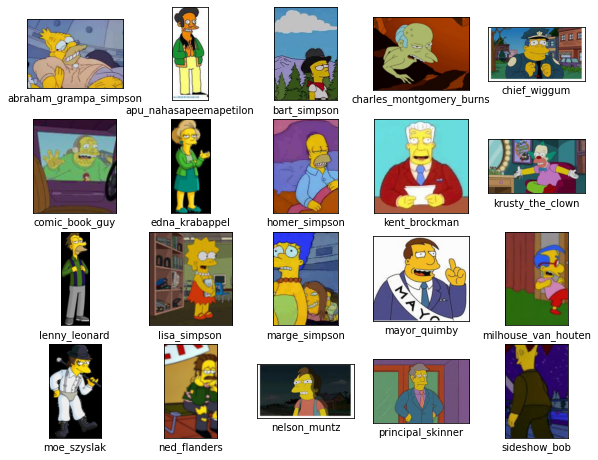

In [64]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = image.imread(directories["dataset"] + character_name + "/pic_0000.jpg")
    plt.imshow(img)
    plt.xlabel(character_name)
plt.show()

## Resizing Images
For testing this code creates the same as above but resized to the standard_resolution variable

In [65]:
standard_resolution = 352
resampling_algorithm = Image.LANCZOS  # todo decide on resampling algorithm

In [66]:
def get_resized_image(image_path):
    img = Image.open(image_path)
    img = img.resize(size=(standard_resolution, standard_resolution),
                     resample=resampling_algorithm)
    img = np.asarray(img)  #store im as numpy array
    # shape of image is ([128x(r,g,b)], [128x(r,g,b)])
    img = np.array(img)
    return img

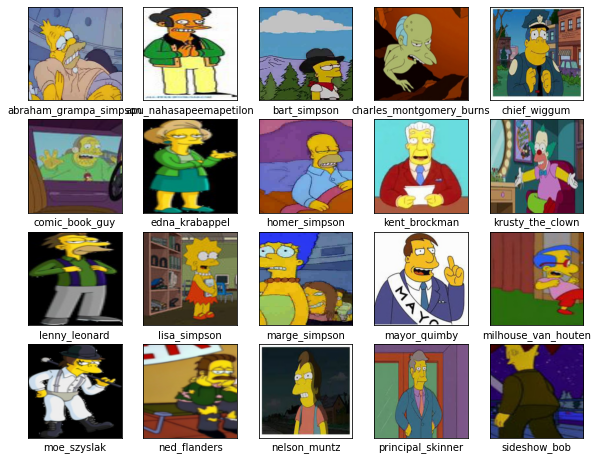

In [67]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(get_resized_image(directories["dataset"] + character_name + "/pic_0000.jpg"))
    plt.xlabel(character_name)
plt.show()

## Load files and split into test data

In [68]:
test_factor = 0.2  # determine what percentage of each character's images should be used for testing

In [81]:
training_images = []  # the images as rgb values
training_labels = []  # the corresponding character name

test_images = []  # the test images as rgb values
test_labels = []  # the corresponding character name

for character_name in selected_characters:  #loop over all selected characters

    current_character_path = directories["dataset"] + character_name + "/"
    current_character_paths_list = glob.glob(current_character_path + "*.jpg")

    # calculate how many files are test data and how many files are training data
    current_character_picture_count = len(current_character_paths_list)
    current_character_test_count = round(current_character_picture_count * test_factor)
    current_character_training_count = round(current_character_picture_count * (1 - test_factor))
    current_image_position = 0

    encoded_character_label = encoded_labels.transform([character_name])
    print("Loading Character:" + character_name + " (label number " + str(encoded_character_label[0]) + ")")
    print("", end='\n')

    for current_image_position, current_character_picture_path in enumerate(
            current_character_paths_list):  #loop over all files ending in .jpg in the current folder
        print("[", current_image_position, "/", current_character_picture_count, "]" + current_character_picture_path,
              end='\r')

        current_character_picture = get_resized_image(current_character_picture_path)  # load picture

        if current_image_position <= current_character_test_count:  # if the current image is still part of the test part add to testing
            test_images.append(current_character_picture)
            test_labels.append(encoded_character_label)
        else:
            training_images.append(current_character_picture)
            training_labels.append(encoded_character_label)
    print("", end='\n')

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

Loading Character:abraham_grampa_simpson (label number 0)

[ 912 / 913 ]./data/archive/simpsons_dataset/abraham_grampa_simpson/pic_0743.jpg
Loading Character:apu_nahasapeemapetilon (label number 1)

[ 622 / 623 ]./data/archive/simpsons_dataset/apu_nahasapeemapetilon/pic_0025.jpg
Loading Character:bart_simpson (label number 2)

[ 1341 / 1342 ]./data/archive/simpsons_dataset/bart_simpson/pic_0743.jpg
Loading Character:charles_montgomery_burns (label number 3)

[ 1192 / 1193 ]./data/archive/simpsons_dataset/charles_montgomery_burns/pic_0743.jpg
Loading Character:chief_wiggum (label number 4)

[ 985 / 986 ]./data/archive/simpsons_dataset/chief_wiggum/pic_0743.jpg
Loading Character:comic_book_guy (label number 5)

[ 468 / 469 ]./data/archive/simpsons_dataset/comic_book_guy/pic_0025.jpg
Loading Character:edna_krabappel (label number 6)

[ 456 / 457 ]./data/archive/simpsons_dataset/edna_krabappel/pic_0025.jpg
Loading Character:homer_simpson (label number 7)

[ 2245 / 2246 ]./data/archive/simp

In [82]:
training_images[0].shape

(352, 352, 3)

## Create Convolutional Neuronal Network

In [83]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(standard_resolution, standard_resolution, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(selected_characters))
])

In [84]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 352, 352, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 352, 352, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 176, 176, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 176, 176, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 88, 88, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 88, 88, 64)       

In [85]:
#from sklearn.preprocessing import LabelEncoder

#df[target_col] = LabelEncoder().fit_transform(df[target_col])

In [86]:
#training_images, test_images = training_images / 255.0, test_images / 255.0

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # SparseCategoricalCrossentropy uses numbered labels instead of hot encoding (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)
    metrics=['accuracy']
)

history = model.fit(
    training_images, training_labels,
    epochs=10,
    # batch_size=16,
    validation_data=(test_images, test_labels)
    # validation_split=0.2
)

Epoch 1/10
489/489 [==============================] - 316s 644ms/step - loss: 2.0207 - accuracy: 0.4163 - val_loss: 1.5387 - val_accuracy: 0.5667
Epoch 2/10
489/489 [==============================] - 314s 643ms/step - loss: 1.0497 - accuracy: 0.6948 - val_loss: 1.2321 - val_accuracy: 0.6590
Epoch 3/10
489/489 [==============================] - 310s 633ms/step - loss: 0.4544 - accuracy: 0.8655 - val_loss: 1.3428 - val_accuracy: 0.6794
Epoch 4/10
489/489 [==============================] - 318s 650ms/step - loss: 0.1399 - accuracy: 0.9595 - val_loss: 1.7911 - val_accuracy: 0.6715
Epoch 5/10
489/489 [==============================] - 310s 634ms/step - loss: 0.0572 - accuracy: 0.9835 - val_loss: 1.9785 - val_accuracy: 0.6702
Epoch 6/10
489/489 [==============================] - 307s 628ms/step - loss: 0.0565 - accuracy: 0.9844 - val_loss: 2.2207 - val_accuracy: 0.6791
Epoch 7/10
489/489 [==============================] - 309s 631ms/step - loss: 0.0404 - accuracy: 0.9875 - val_loss: 2.3194 -

## Export model

In [87]:
model.save_weights('./models/simpsons')

## Visualise the Network

123/123 - 21s - loss: 2.1685 - accuracy: 0.6921 - 21s/epoch - 171ms/step


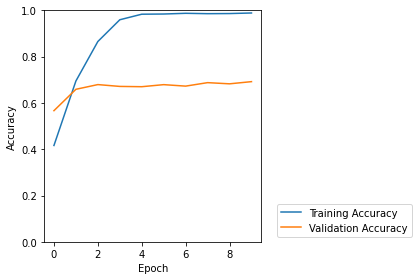

In [88]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("accuracy.png", dpi=300)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

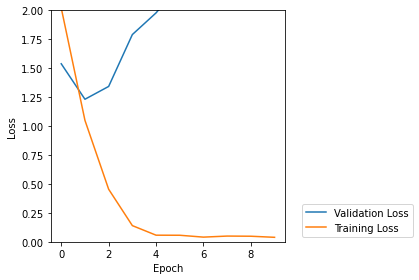

In [89]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("loss.png", dpi=300)

## Load the test dataset

In [91]:
def load_test_set():
    pics, labels = [], []
    for all_test_pictures in glob.glob(directories["testset"] + '*.jpg'):
        file_name = all_test_pictures.split("/")[
            -1]  # './data/archive/kaggle_simpson_testset/kaggle_simpson_testset/principal_skinner_34.jpg'
        character_name_with_number = file_name.split(".jpg")[-2]  # 'principal_skinner_34'
        character_name_clean = character_name_with_number.rsplit('_', 1)[0]  # 'principal_skinner'

        if character_name_clean in selected_characters:
            character_label = encoded_labels.transform([character_name_clean])
            temp = get_resized_image(all_test_pictures)
            pics.append(temp)
            labels.append(character_label)
    x_test = np.array(pics)
    y_test = np.array(labels)
    print("Test set", x_test.shape, y_test.shape)
    return x_test, y_test

In [92]:
x_test, y_test = load_test_set()
prediction = model.predict(x_test)

Test set (990, 352, 352, 3) (990, 1)


## Confusion Matrix

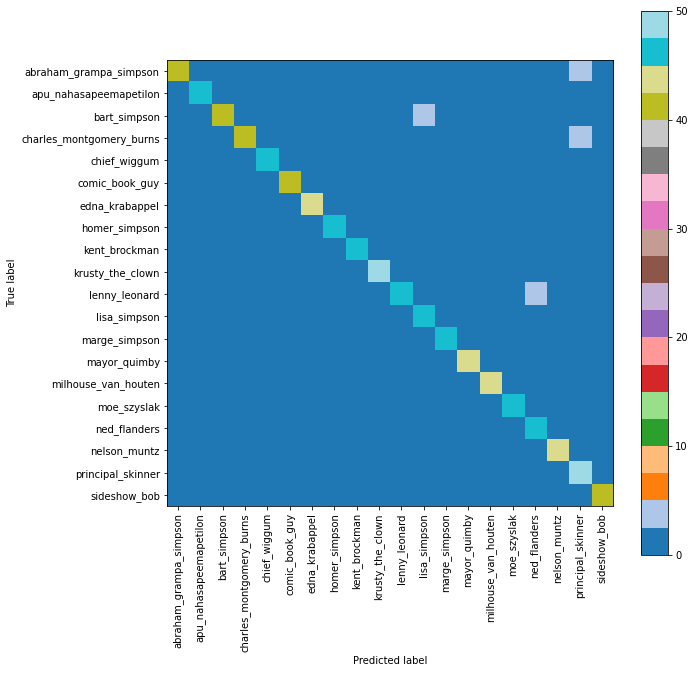

In [93]:
plt.figure(figsize=(10, 10))
labels = list(encoded_labels.classes_)
cm = metrics.confusion_matrix(y_test, np.argmax(prediction, axis=1))
tick_marks = np.arange(len(labels))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.tab20)
plt.colorbar()
_ = plt.xticks(tick_marks, labels, rotation=90)
_ = plt.yticks(tick_marks, labels)
plt.savefig("confusion_matrix.png", dpi=300)
#p = metrics.ConfusionMatrixDisplay(cm, display_labels=labels).plot()

## Simple Predictions

In [ ]:
prediction_images = []

current_character_picture = get_resized_image(directories["testset"] + "bart_simpson_24.jpg")

#im = current_character_picture / 255.0
#img_array = tf.expand_dims(im, 0)  # Create a batch

img_array = tf.expand_dims(current_character_picture, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

#print(predictions[0])
#print(score)

#print(100 * np.max(score))

#print(np.argmax(predictions))
#print([labels[i] for i,prob in enumerate(predictions) if prob > 0.5])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(encoded_labels.inverse_transform([np.argmax(score)])[0], 100 * np.max(score))
)